In [1]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
lib6 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts/preprocess_data'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
sys.path.append(lib6)
from classifying_cell_types import *
import numpy as np
import pandas as pd
import scipy
from os.path import join
import sklearn
from sklearn.manifold import TSNE
import pickle
# from Bio.Cluster import kcluster
import os
import numpy as np
import yaml
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import pyclustering
import matplotlib.pylab as plt
import seaborn as sb
from scipy.spatial.distance import cdist

from shutil import copyfile
import matplotlib.pyplot as plt

from utilities.general_helpers import flatten_list
import os
from os.path import join
import sklearn
from droplet_dataset import *
from utilities import *
from matplotlib import pyplot
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random
from scipy.stats import pearsonr
from matplotlib.pyplot import figure
sklearn.__version__
%matplotlib notebook
# ------- SERVER EXTENSIONS ---------

# Load cohort

In [5]:
cohort_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_10.6.21.pkl'
normalized_cohort = pickle.load(open(cohort_path, 'rb'))
immune_cells = normalized_cohort.filter_cells_by_property('is_immune', True)
immune_cells.number_of_cells

Loads immune markers table

In [7]:
MARKERS_PATH = r'/storage/md_keren/shitay/Data/tables/ImmuneCellsMarkersUpdated_12.11.20.xlsx'

xls = pd.ExcelFile(MARKERS_PATH)
positive_markers_df = pd.read_excel(xls, 'and_or')
negative_markers_df = pd.read_excel(xls, 'none')


positive_markers_table = builds_cell_type_markers_table(positive_markers_df)
negative_markers_table = builds_cell_type_markers_table(negative_markers_df)


cell_types_markers_mapping = {k: [vv.split(';') for vv in v] for k,v in positive_markers_table.items()}
cell_types_markers_mapping = {k: flatten_list(v) for k,v in cell_types_markers_mapping.items()}
markers_cell_types_mapping = {}
for k, v in cell_types_markers_mapping.items():
    for marker in v:
        if marker in markers_cell_types_mapping.keys():
            markers_cell_types_mapping[marker].append(k)
        else:
            markers_cell_types_mapping[marker] = [k]

REDUCED_MHC2_GENES = ['HLA-DMA',  'HLA-DMB',  'HLA-DOA',  'HLA-DOB',
                      'HLA-DPA1',  'HLA-DPB1',  'HLA-DQA1',  'HLA-DQB1',
                      'HLA-DQB2',  'HLA-DRA',  'HLA-DRB1',  'HLA-DRB5']
for MHCII_gene in REDUCED_MHC2_GENES:
    markers_cell_types_mapping[MHCII_gene] = markers_cell_types_mapping['MHCII']
    
markers_cell_types_mapping.pop('MHCII' ,None);

for each immune marker we see in markers_cell_types_mapping the corresponding cell-types

In [8]:
immune_markers = list(markers_cell_types_mapping.keys())
len(immune_markers)
gene_index = [immune_cells.gene_names.index(vv) for vv in immune_markers]
immune_gene_values = np.round(immune_cells.counts[:, gene_index])

In [11]:
fib_genes = np.array([[idx, g] for idx, g in enumerate(immune_cells.gene_names) if g.startswith('COL1') or g.startswith('COL2') or g.startswith('KRT')])
fib_gene_values = np.round(immune_cells.counts[:, fib_genes[:,0].astype(int).tolist()])
# np.round(fib_gene_values)

##### How many immune cells express 1 or more fib markers

In [66]:
count_immune_cells_expressing_fib =  dict(Counter(np.sum(np.round(immune_cells.counts[:, fib_genes[:,0].astype(int).tolist()])>0, axis=1)))

max_markers = np.max(list(count_immune_cells_expressing_fib.keys()))

more_or_equal_dic = {i:0 for i in range(max_markers+1)}
for n_fib_genes, amount in count_immune_cells_expressing_fib.items():
    for i in range(n_fib_genes+1):
        more_or_equal_dic[i] += amount
for i in range(max_markers+1):
    print(f'{more_or_equal_dic[i]} ({round(more_or_equal_dic[i]/immune_cells.number_of_cells*100, 2)}%) immune cells express {i} or more fib markers')

83661 (100.0%) immune cells express 0 or more fib markers
52760 (63.06%) immune cells express 1 or more fib markers
18733 (22.39%) immune cells express 2 or more fib markers
4633 (5.54%) immune cells express 3 or more fib markers
2638 (3.15%) immune cells express 4 or more fib markers
1857 (2.22%) immune cells express 5 or more fib markers
1259 (1.5%) immune cells express 6 or more fib markers
876 (1.05%) immune cells express 7 or more fib markers
638 (0.76%) immune cells express 8 or more fib markers
397 (0.47%) immune cells express 9 or more fib markers
188 (0.22%) immune cells express 10 or more fib markers
71 (0.08%) immune cells express 11 or more fib markers
25 (0.03%) immune cells express 12 or more fib markers
14 (0.02%) immune cells express 13 or more fib markers
6 (0.01%) immune cells express 14 or more fib markers
3 (0.0%) immune cells express 15 or more fib markers
1 (0.0%) immune cells express 16 or more fib markers
1 (0.0%) immune cells express 17 or more fib markers


##### How many T cells express 1 or more fib markers

In [60]:
T_cells = immune_cells[['T cells' in cc for cc in immune_cells.cells_information.getattr('cell_type_list')]]
count_T_cells_expressing_fib =  dict(Counter(np.sum(np.round(T_cells.counts[:, fib_genes[:,0].astype(int).tolist()])>0, axis=1)))

max_markers = np.max(list(count_T_cells_expressing_fib.keys()))

more_or_equal_dic = {i:0 for i in range(max_markers+1)}
for n_fib_genes, amount in count_T_cells_expressing_fib.items():
    for i in range(n_fib_genes+1):
        more_or_equal_dic[i] += amount
for i in range(max_markers+1):
    print(f'{more_or_equal_dic[i]} ({round(more_or_equal_dic[i]/T_cells.number_of_cells*100, 2)}%) T cells express {i} or more fib markers')

49553 (100.0%) T cells express 0 or more fib markers
30866 (62.29%) T cells express 1 or more fib markers
9064 (18.29%) T cells express 2 or more fib markers
872 (1.76%) T cells express 3 or more fib markers
194 (0.39%) T cells express 4 or more fib markers
106 (0.21%) T cells express 5 or more fib markers
65 (0.13%) T cells express 6 or more fib markers
38 (0.08%) T cells express 7 or more fib markers
26 (0.05%) T cells express 8 or more fib markers
14 (0.03%) T cells express 9 or more fib markers
5 (0.01%) T cells express 10 or more fib markers
3 (0.01%) T cells express 11 or more fib markers
1 (0.0%) T cells express 12 or more fib markers
1 (0.0%) T cells express 13 or more fib markers
1 (0.0%) T cells express 14 or more fib markers


##### How many lymphoid cells express 1 or more fib markers

In [64]:
lymphoid_cells = immune_cells[immune_cells.cells_information.getattr('is_lymphoid')]
count_lymphoid_cells_expressing_fib =  dict(Counter(np.sum(np.round(lymphoid_cells.counts[:, fib_genes[:,0].astype(int).tolist()])>0, axis=1)))

max_markers = np.max(list(count_lymphoid_cells_expressing_fib.keys()))

more_or_equal_dic = {i:0 for i in range(max_markers+1)}
for n_fib_genes, amount in count_lymphoid_cells_expressing_fib.items():
    for i in range(n_fib_genes+1):
        more_or_equal_dic[i] += amount
for i in range(max_markers+1):
    print(f'{more_or_equal_dic[i]} ({round(more_or_equal_dic[i]/lymphoid_cells.number_of_cells*100, 2)}%) lymphoid cells express {i} or more fib markers')

59152 (100.0%) lymphoid cells express 0 or more fib markers
36647 (61.95%) lymphoid cells express 1 or more fib markers
10954 (18.52%) lymphoid cells express 2 or more fib markers
1157 (1.96%) lymphoid cells express 3 or more fib markers
249 (0.42%) lymphoid cells express 4 or more fib markers
135 (0.23%) lymphoid cells express 5 or more fib markers
81 (0.14%) lymphoid cells express 6 or more fib markers
45 (0.08%) lymphoid cells express 7 or more fib markers
29 (0.05%) lymphoid cells express 8 or more fib markers
15 (0.03%) lymphoid cells express 9 or more fib markers
5 (0.01%) lymphoid cells express 10 or more fib markers
3 (0.01%) lymphoid cells express 11 or more fib markers
1 (0.0%) lymphoid cells express 12 or more fib markers
1 (0.0%) lymphoid cells express 13 or more fib markers
1 (0.0%) lymphoid cells express 14 or more fib markers


##### How many myeloid cells express 1 or more fib markers

In [65]:
myeloid_cells = immune_cells[immune_cells.cells_information.getattr('is_myeloid')]
count_myeloid_cells_expressing_fib =  dict(Counter(np.sum(np.round(myeloid_cells.counts[:, fib_genes[:,0].astype(int).tolist()])>0, axis=1)))

# THRESHOLD = 2 # >, greater than 

# n_cells = 0
# for n_fib_genes, amount in count_myeloid_cells_expressing_fib.items():
#     if n_fib_genes > THRESHOLD:
#         n_cells += amount
# print(f'{n_cells} ({round(n_cells/myeloid_cells.number_of_cells*100, 2)}%) myeloid cells expressing more than {THRESHOLD} fib markers')

max_markers = np.max(list(count_myeloid_cells_expressing_fib.keys()))

more_or_equal_dic = {i:0 for i in range(max_markers+1)}
for n_fib_genes, amount in count_myeloid_cells_expressing_fib.items():
    for i in range(n_fib_genes+1):
        more_or_equal_dic[i] += amount
for i in range(max_markers+1):
    print(f'{more_or_equal_dic[i]} ({round(more_or_equal_dic[i]/myeloid_cells.number_of_cells*100, 2)}%) myeloid cells express {i} or more fib markers')

13675 (100.0%) myeloid cells express 0 or more fib markers
9698 (70.92%) myeloid cells express 1 or more fib markers
4806 (35.14%) myeloid cells express 2 or more fib markers
1780 (13.02%) myeloid cells express 3 or more fib markers
1148 (8.39%) myeloid cells express 4 or more fib markers
853 (6.24%) myeloid cells express 5 or more fib markers
673 (4.92%) myeloid cells express 6 or more fib markers
547 (4.0%) myeloid cells express 7 or more fib markers
458 (3.35%) myeloid cells express 8 or more fib markers
299 (2.19%) myeloid cells express 9 or more fib markers
140 (1.02%) myeloid cells express 10 or more fib markers
53 (0.39%) myeloid cells express 11 or more fib markers
19 (0.14%) myeloid cells express 12 or more fib markers
10 (0.07%) myeloid cells express 13 or more fib markers
4 (0.03%) myeloid cells express 14 or more fib markers
2 (0.01%) myeloid cells express 15 or more fib markers
1 (0.01%) myeloid cells express 16 or more fib markers
1 (0.01%) myeloid cells express 17 or mor

# TODO: continue

<IPython.core.display.Javascript object>


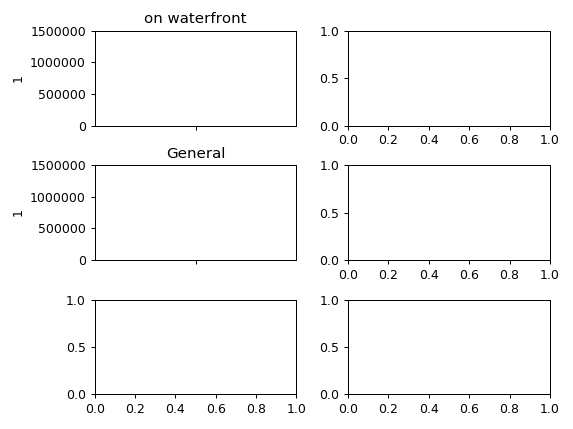

In [43]:
fig, axs = plt.subplots(3, 2)

df = pd.DataFrame([[1,2], [3,4]])

g1 = sns.barplot(y=1, data=df, ci='sd', ax=axs[0][0], estimator=np.median);
g1.set(ylim=(0, 1500000));
axs[0][0].set_title('on waterfront')

g2 = sns.barplot(y=1, data=df, ci='sd', ax=axs[1][0], color="y", estimator=np.median);
g2.set(ylim=(0, 1500000));
axs[1][0].set_title('General')


fig.tight_layout()

<IPython.core.display.Javascript object>


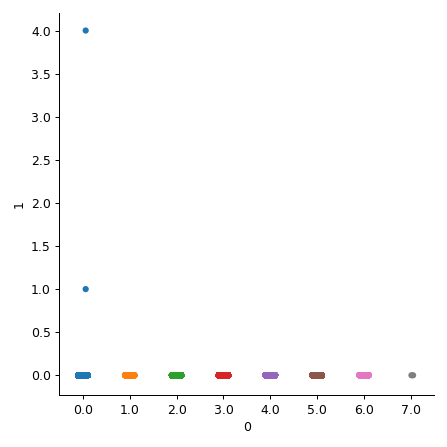

In [111]:
arr = np.concatenate([immune_gene_values[:,0][..., np.newaxis], fib_gene_values[:,0][..., np.newaxis]], axis=1)
df = pd.DataFrame(arr)
# df = pd.DataFrame()
sns.catplot(x=0, y=1, data=df);


In [69]:
np.round(immune_gene_values[[0,1]])


array([[5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 4., 0., 0.,
        0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 2., 2., 0., 0., 0.,
        0., 0., 0., 0., 2., 0., 0., 4., 5., 0., 2., 0., 3., 2.]])